# Initial walkers

In simple_fit we performed many runs of the optimizers and then we uses that information to initialize walkers in the MCMC. Here we illustrate the different strategies to initialize walkers and how to decide the best option.

In [1]:
import nauyaca as nau

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

Instead of defining again the Planetary System we used in simple_fit example, let's load MySystem.json file containing all the information from that system.

In [4]:
PS = nau.PlanetarySystem.load_json('MySystem.json')

# See a summary of the Planetary System
print(PS)

--> Parameter -mass- of planet -Planet-b- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-b- set to lower physical limit: 1e-06
--> Parameter -mass- of planet -Planet-c- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-c- set to lower physical limit: 1e-06
--> Parameter -mass- of planet -Planet-d- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-d- set to lower physical limit: 1e-06

 =========== Planetary System Summary =========== 
--> Parameter -mass- of planet -Planet-b- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-b- set to lower physical limit: 1e-06
--> Parameter -mass- of planet -Planet-c- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-c- set to lower physical limit: 1e-06
--> Parameter -mass- of planet -Planet-d- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-d- set to lower physical limit: 1e-06

Syste

Now, let's call the results from the optimizers. You will realize that there are two files ending with '.opt' and suffixes "_cube" and "_phys" in the simple_fit directory. These correspond to the results in the normalized boundaries and in the physical values, respectively.


### Visualizing optimizer results

Let's inspect pairwise results using the physical results ('_phys')

In [5]:
physical = np.genfromtxt('MySystem_phys.opt')

Select a pair of parameters to visualize. Remember that the valid parameters can be consulted by:

In [6]:
print("Valid parameters are: ")
print(PS.params_names.split())

Valid parameters are: 
['mass1', 'period1', 'ecc1', 'argument1', 'mean_anomaly1', 'ascending_node1', 'mass2', 'period2', 'ecc2', 'inclination2', 'argument2', 'mean_anomaly2', 'ascending_node2', 'mass3', 'period3', 'ecc3', 'argument3', 'mean_anomaly3']


For example, for the masses space:

In [7]:
x, y = 'mass1', 'mass2'

A dictionary with param names

In [8]:
dparam = dict(list(zip(PS.params_names.split(), range(PS.ndim))))

Separate data from the file: chi2 and solutions

Text(0, 0.5, 'mass2')

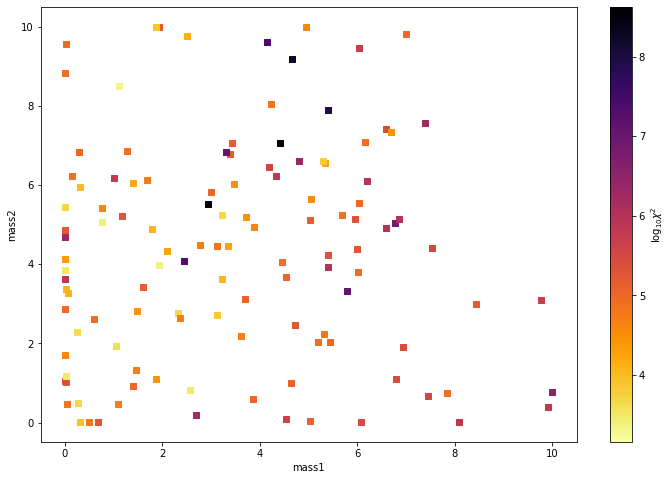

In [9]:
chi2 = physical.T[0]
phys = physical[:,1:].T

cx = phys[dparam[x]]
cy = phys[dparam[y]]

#Plot all the solutions from the optimizers
plt.figure(figsize=(12,8))
plt.scatter(cx, cy, 
            c=np.log10(chi2), 
            cmap='inferno_r', marker='s',
            label='Results from optimizers')
cb = plt.colorbar()
cb.set_label(r'$\log_{10} \chi^2$')
plt.xlabel(x)
plt.ylabel(y)

These are ALL the solutions found by optimizers. Can you identify the region where the best solutions are?

### Generate initial walkers

Given the normalized solutions, select an strategy to initialize walkers. Here you need to provide the NORMALIZED ("_cube") values. The results are normalized between the stablished boundaries for each parameter. Nauyaca will interpret these normalized solutions in the physical space to make the simulations.

Let's see the three strategies included in nauyaca. For this example let's create a temperature ladder of 9 temperatures with 100 walkers each. We will take the best 30% of the optimizer solutions.

In [29]:
temperatures = 9
walkers = 100
best = 0.1   # Change value between 0 and 1

#### Gaussian

In [30]:
wk_gauss = nau.utils.init_walkers(PS, 
                            opt_data= np.genfromtxt('MySystem_cube.opt'),
                            ntemps=temperatures,
                            nwalkers=walkers, 
                            distribution='Gaussian',
                            fbest=best)               


# Convert initial walkers to physical  values
wk_gauss_phys = [nau.utils.cube_to_physical(PS, i) for i in wk_gauss.reshape(-1, wk_gauss.shape[-1]) ]

# Remove the constants added in the previous line
wk_gauss_phys = np.array([nau.utils._remove_constants(PS, i) for i in wk_gauss_phys])
wk_gauss_phys = wk_gauss_phys.reshape((temperatures,walkers,PS.ndim) )


--> Selected distribution: Gaussian
    12 of 120 solutions taken


#### Picked 

In [31]:
wk_pick = nau.utils.init_walkers(PS, 
                            opt_data= np.genfromtxt('MySystem_cube.opt'),
                            ntemps=temperatures,
                            nwalkers=walkers, 
                            distribution='Picked',
                            fbest=best)               


# Convert initial walkers to physical  values
wk_pick_phys = [nau.utils.cube_to_physical(PS, i) for i in wk_pick.reshape(-1, wk_pick.shape[-1]) ]

# Remove the constants added in the previous line
wk_pick_phys = np.array([nau.utils._remove_constants(PS, i) for i in wk_pick_phys])
wk_pick_phys = wk_pick_phys.reshape((temperatures,walkers,PS.ndim) )


--> Selected distribution: Picked
    12 of 120 solutions taken


#### Ladder

In [32]:
wk_ladd = nau.utils.init_walkers(PS, 
                            opt_data= np.genfromtxt('MySystem_cube.opt'),
                            ntemps=temperatures,
                            nwalkers=walkers, 
                            distribution='Ladder',
                            fbest=best)               


# Convert initial walkers to physical  values
wk_ladd_phys = [nau.utils.cube_to_physical(PS, i) for i in wk_ladd.reshape(-1, wk_ladd.shape[-1]) ]

# Remove the constants added in the previous line
wk_ladd_phys = np.array([nau.utils._remove_constants(PS, i) for i in wk_ladd_phys])
wk_ladd_phys = wk_ladd_phys.reshape((temperatures,walkers,PS.ndim) )


--> Selected distribution: Ladder
    12 of 120 solutions taken


From the cells above, note that nau.utils.init_walkers() generates initial walkers in the normalized form! It's because nauyaca works internally in this way to homogenize the scales at different dimensions. Thus, we need to convert to physical values using the function nau.utils.cube_to_physical(). From this function we obtain physical solutions including the constant parameters. For simplicity, we remove these constants by means of the function nau.utils._remove_constants().

### Visualizing the initial walkers

Let's visualize these strategies overplotted on the discrete optimizer solutions. 

In [33]:
# Change these parameters to generate new plots
x, y = 'mass1', 'mass2'

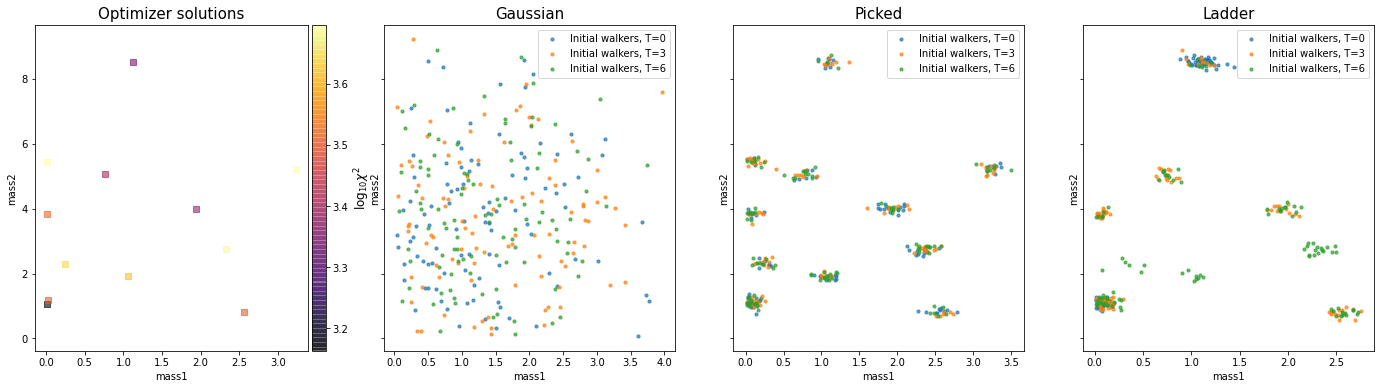

In [34]:
X = np.array(sorted(physical, key=lambda x: x[0]))

chi2 = X.T[0]
phys = X[:,1:].T

cx = phys[dparam[x]]
cy = phys[dparam[y]]

upto = int(len(chi2)*best)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24,6), sharey='row')

#Plot all the solutions from the optimizers
im = axes[0].scatter(cx[:upto], cy[:upto], 
            c=np.log10(chi2[:upto]), marker='s',
            cmap='inferno', alpha=0.6,
            label='Results from optimizers')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
cb.set_label(r'$\log_{10} \chi^2$',fontsize=12)

axes[0].set_title('Optimizer solutions', fontsize=15)
axes[0].set_xlabel(x)
axes[0].set_ylabel(y)

for i, strategy in enumerate([(wk_gauss_phys, 'Gaussian'), 
                            (wk_pick_phys, 'Picked'), 
                            (wk_ladd_phys, 'Ladder')]):
    
    wk, strat = strategy
    
    each = 3
    for t, wk_t in enumerate(wk[::each, :, :]):
        # Plot the new generated initial walkers
        axes[i+1].scatter(wk_t[:,dparam[x]], 
                        wk_t[:,dparam[y]], 
                        s=10,  alpha=0.7,
                        label=f'Initial walkers, T={t*each}')
    
    axes[i+1].set_title(strat, fontsize=15)
    axes[i+1].legend(loc='upper right')
    axes[i+1].set_xlabel(x)
    axes[i+1].set_ylabel(y)

plt.savefig(f"optimizers_{x}_{y}.pdf")

In the figure above, the initial walkers are drawn around the best 30% (fbest=0.3) of the full optimizer results (shown in the first panel). The walkers belonging to each temperature are colored differently. For clarity, only walkers belonging to temperatures 0 (the main), 3 and 6 are shown.

But, which are the differences in these strategies? 

    For the Gaussian strategy, the initial distribution is drawn as usual. It is calculated a mean and standard deviation from the selected optimizer results, and walkers are drawn below a gaussian. In this case, the space of the nascent walkers is broader.

    In the Picked strategy, the walkers are drawn indistinctly of the temperatures they belong. It means that you can find walkers of any temperature around the meaningful modes in the parameter space. 

    In the last strategy, Ladder, walkers belonging to the coldest temperature (the 0) are drawn around the solutions with the lowest $\chi^2$ (yellow squares). Complementarily, walkers at higher temperatures are drawn from solutions with increasingly $\chi^2$ values.  By doing this, more walkers are destined to sample the zone with the best of all the solutions, although other zones are explored but to a lesser extent.

Which is more adequate to solve my TTVs problem?

It would depend on the available number of optimizer results as well as the confinement of the solutions to a global consensus. In other words, if you're able to identify a global region where the best solutions accumulate, then a gaussian initialization would be adequate. But, if there are many modes along all the dimensions, then the Picked strategy would be more suitable. In cases where a global minimum is recognizable but many other modes exist, the Ladder strategy would be more reasonable.

If nothing is known about the parameter space, or if you are running nauyaca in a non-interactive way (for example if you have not time to visualize optimizer results) I would strongly recommend using the Ladder strategy.


### What's next?

After generating the initial walkers we can initialize the MCMC by setting the kwarg -p0- just as in the customized_fit example. The main difference with that example is that here our initial walker population is normalized and not in physical values as before (see customized_fit). Anyway, nauyaca will identify if we are setting -p0- with normalized or physical values and it will go ahead.

The following cells show two ways of running the mcmc with the information from optimizers. These are equivalent.

An alternate way of running the MCMC without creating initial walkers explicitly (by means of the nau.utils.init_walkers() function) is by providing  the necessary attributes to the MCMC class.

If you're curious, try running these cells.

_________________